In [1]:
import os
import cv2
import random
import threading
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.layers import Input
from keras.layers import ZeroPadding2D
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Lambda
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import SpatialDropout2D
from keras.layers import Multiply
from keras.models import Model

from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
from tensorflow import set_random_seed
set_random_seed(42)
np.random.seed(42)
random.seed(42)

# Set Parameter

In [3]:
INPUT_SHAPE = (321, 321, 3)
DROPOUT_SHAPE = (189, 189, 1)
# DROPOUT_SHAPE = (369, 369, 1)
CLASSES = 21 # PASCAL VOC 2012
LR = 0.0001
OPTIMIZER = Adam(LR)
s = 9 # kernel size
p = 0.9 # dropout rate
N = 200 # the number of difference localization maps
theta = 0.35 # threshold
alpha = 2 # weight for semi-supervised learning
batch_size = 10

# Set backbone network

In [4]:
img_input = Input(shape=INPUT_SHAPE)

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block4_pool')(x)

# Block 5
# # 4.1. Experimental Setup - Network details
x = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), name='block5_conv3')(x)

vgg = Model(img_input, x, name='vgg16')
vgg.load_weights('/home/sungchul/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [5]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 321, 321, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 321, 321, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 321, 321, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 161, 161, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 161, 161, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 161, 161, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 81, 81, 128)       0         
__________

In [6]:
# vgg.trainable = False

# Set classification model

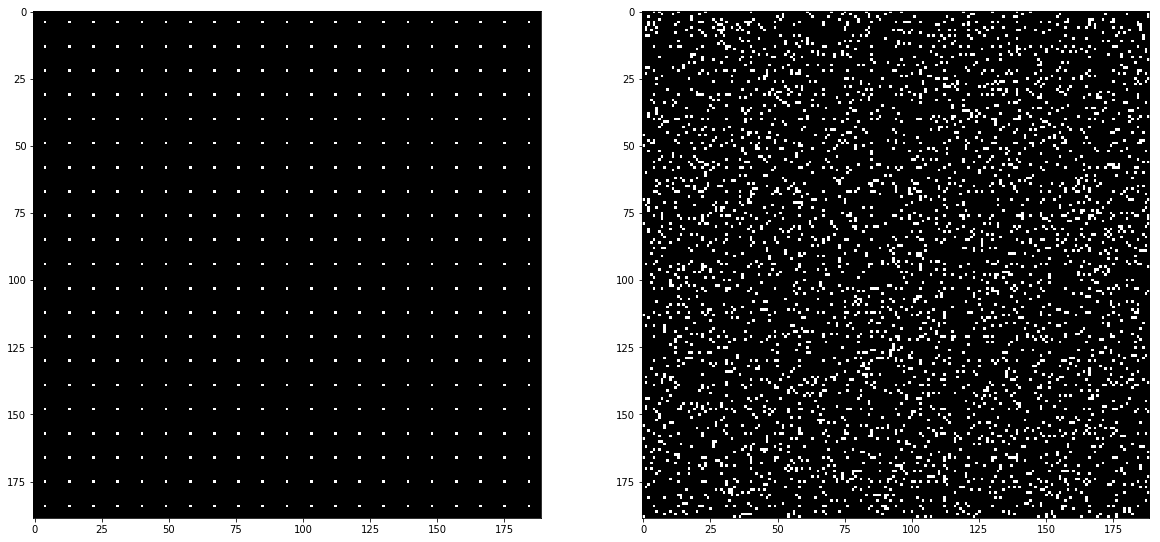

In [6]:
mat = np.zeros((DROPOUT_SHAPE[:2]))

for i in range(int(np.ceil((DROPOUT_SHAPE[0]-s//2)/s))):
    for j in range(int(np.ceil((DROPOUT_SHAPE[1]-s//2)/s))):
        mat[s//2+s*i,s//2+s*j] = 1

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(mat, 'gray')
mat1 = mat.copy()
ranlist = np.random.permutation(len(np.where(mat == 0)[0]))

mat[np.where(mat == 0)[0][ranlist[:int(DROPOUT_SHAPE[0]*DROPOUT_SHAPE[1]*(1-p))-len(np.where(mat == 1)[0])]],
    np.where(mat == 0)[1][ranlist[:int(DROPOUT_SHAPE[0]*DROPOUT_SHAPE[1]*(1-p))-len(np.where(mat == 1)[1])]]] = 1

plt.subplot(122)
plt.imshow(mat, 'gray')
plt.show()

In [7]:
x = vgg.output
dropout_map = Input(DROPOUT_SHAPE)

# 3.1.1 Feature Map Expansion
x_pad = ZeroPadding2D(padding=(s//2, s//2))(x)
x_expand = Lambda(lambda img: K.tf.image.resize_images(img, (K.int_shape(x)[1]*s, K.int_shape(x)[2]*s), method=1))(x_pad)

# 3.1.2 Center-preserving Spatial Dropout
x_dropout = Multiply()([x_expand, dropout_map])

# 3.1.3 Classification
x = Conv2D(CLASSES, (s, s), strides=(s, s))(x_dropout)
x = GlobalAveragePooling2D()(x)
x = Activation('sigmoid')(x)

backbone = Model([vgg.input, dropout_map], x)
backbone.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 321, 321, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 321, 321, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 321, 321, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 161, 161, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [8]:
backbone.compile(optimizer=OPTIMIZER,
                 loss=binary_crossentropy,
                 metrics=['acc'])

In [85]:
backbone.load_weights('./checkpoint/classification_0009_0.9619.h5')

# Set data pipeline

In [12]:
class_dict = {'background' : 0,
              'aeroplane' : 1,
              'bicycle' : 2,
              'bird' : 3,
              'boat' : 4,
              'bottle' : 5,
              'bus' : 6,
              'car' : 7,
              'cat' : 8,
              'chair' : 9,
              'cow' : 10,
              'diningtable' : 11,
              'dog' : 12,
              'horse' : 13,
              'motorbike' : 14,
              'person' : 15,
              'pottedplant' : 16,
              'sheep' : 17,
              'sofa' : 18,
              'train' : 19,
              'tvmonitor' : 20}

In [13]:
INPUT_FOLDER = '../../dataset/VOC2012/train/JPEGImages/'
XML_FOLDER = '../../dataset/VOC2012/train/Annotations/'
with open('../../dataset/VOC2012/trainaug.txt', 'r') as f:
    imgaug_list = [d[:-1] for d in f.readlines()] # 10,582 dataset

In [14]:
imgaug_list[:5]

['2007_000032', '2007_000039', '2007_000063', '2007_000068', '2007_000121']

2007_000032.jpg 
 [500, 281, 3] 
 ['aeroplane', 'aeroplane', 'person', 'person'] 
 [[104, 78, 375, 183], [133, 88, 197, 123], [195, 180, 213, 229], [26, 189, 44, 238]]


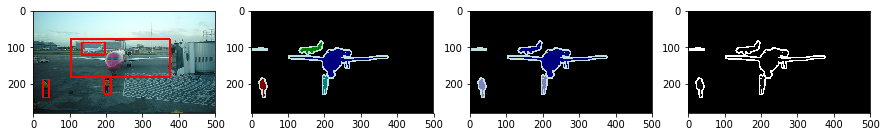

In [15]:
import xml.etree.ElementTree as ET

def read_content(xml_file: str):
    '''https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python
    '''
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    filename = root.find('filename').text
    boxes = []
    imgsize = []
    classes = []
    for s in root.iter('size'):
        imgsize.append(int(s.find("width").text))
        imgsize.append(int(s.find("height").text))
        imgsize.append(int(s.find("depth").text))
    for bb in root.iter('object'):
        cls = bb.find("name").text
        ymin, xmin, ymax, xmax = None, None, None, None
        for b in bb.findall("bndbox"):
            ymin = int(float(b.find("ymin").text))
            xmin = int(float(b.find("xmin").text))
            ymax = int(float(b.find("ymax").text))
            xmax = int(float(b.find("xmax").text))

        box = [xmin, ymin, xmax, ymax]
        boxes.append(box)
        classes.append(cls)

    return filename, classes, imgsize, boxes

filename, classes, imgsize, boxes = read_content(XML_FOLDER+'2007_000032.xml')
print(filename, '\n', imgsize, '\n', classes, '\n', boxes)

img = cv2.cvtColor(cv2.imread(INPUT_FOLDER+filename), cv2.COLOR_BGR2RGB)
mask1 = cv2.imread('../../dataset/VOC2012/train/SegmentationObject/2007_000032.png') # For Instance Segmentation
mask2 = cv2.imread('../../dataset/VOC2012/train/SegmentationClass/2007_000032.png') # For Semantic Segmentation
mask3 = cv2.imread('../../dataset/VOC2012/train/SegmentationClassAugRaw/2007_000032.png') # For Semantic Segmentation with only boundary line
for b in boxes:
    img = cv2.rectangle(img, tuple(b[:2]), tuple(b[2:]), (255,0,0), thickness=3)
plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(img)
plt.subplot(142)
plt.imshow(mask1)
plt.subplot(143)
plt.imshow(mask2)
plt.subplot(144)
plt.imshow(mask3)
plt.show()

In [16]:
# set generator
class threadsafe_iter:
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)

def threadsafe_generator(f):
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

def _set_dropoutmap(dropout_shape, kernel_size, dropout_rate):
    mat = np.zeros(dropout_shape)
    for i in range(int(np.ceil((dropout_shape[0]-kernel_size//2)/kernel_size))):
        for j in range(int(np.ceil((dropout_shape[1]-kernel_size//2)/kernel_size))):
            mat[s//2+s*i,s//2+s*j] = 1

    ranlist = np.random.permutation(len(np.where(mat == 0)[0]))
    numlimit = int(dropout_shape[0]*dropout_shape[1]*(1-dropout_rate))-len(np.where(mat == 1)[0])
    mat[np.where(mat == 0)[0][ranlist[:numlimit]],
        np.where(mat == 0)[1][ranlist[:numlimit]]] = 1
    return mat

@threadsafe_generator
def generator(datalist,
              input_shape,
              dropout_shape,
              kernel_size,
              batch_size,
              dropout_rate,
              shuffle=True):
    
    def _random_crop(image, crop_shape):
        if (crop_shape[0] < image.shape[1]) and (crop_shape[1] < image.shape[0]):
            x = random.randrange(image.shape[1]-crop_shape[0])
            y = random.randrange(image.shape[0]-crop_shape[1])
            return image[y:y+crop_shape[1], x:x+crop_shape[0], :]
        else:
            image = cv2.resize(image, crop_shape)
            return image
    
    img_input = np.zeros((batch_size,)+input_shape)
    mat_input = np.zeros((batch_size,)+dropout_shape)
    label_input = np.zeros((batch_size, CLASSES))
    batch = 0
    while True:
        if shuffle:
            random.shuffle(datalist)
            
        for data in datalist:
            filename, classes, imgsize, boxes = read_content(XML_FOLDER+data+'.xml')
            img = cv2.cvtColor(cv2.imread(INPUT_FOLDER+filename), cv2.COLOR_BGR2RGB)
            img = _random_crop(img, input_shape[:2]).astype('float32')
            img /= 255.
            
            mat_input[batch] = _set_dropoutmap(dropout_shape, kernel_size, dropout_rate)
            
            label = np.zeros((CLASSES,))
            for c in classes:
                label[class_dict[c]] = 1
            
            img_input[batch] = img
            label_input[batch] = label
            batch += 1
        
            if batch >= batch_size:
                yield [img_input, mat_input], label_input
                img_input = np.zeros((batch_size,)+input_shape)
                label_input = np.zeros((batch_size, len(class_dict)))
                batch = 0

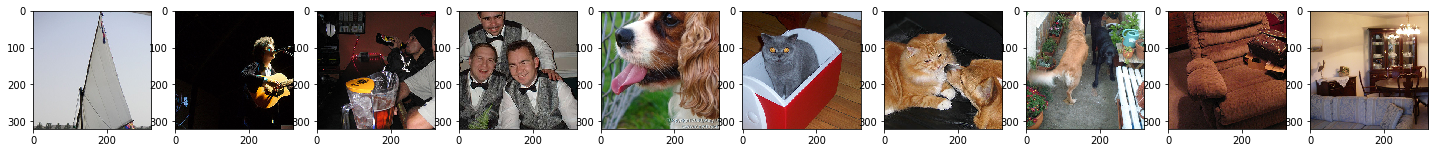

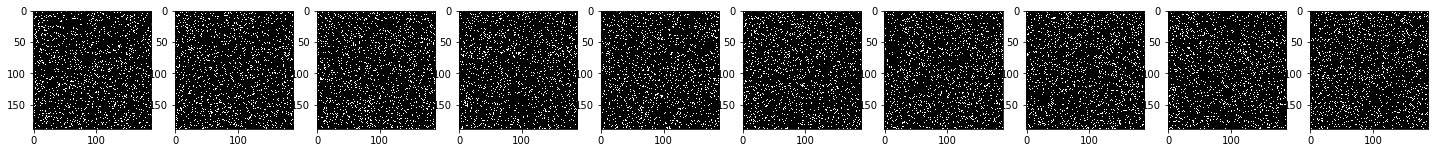

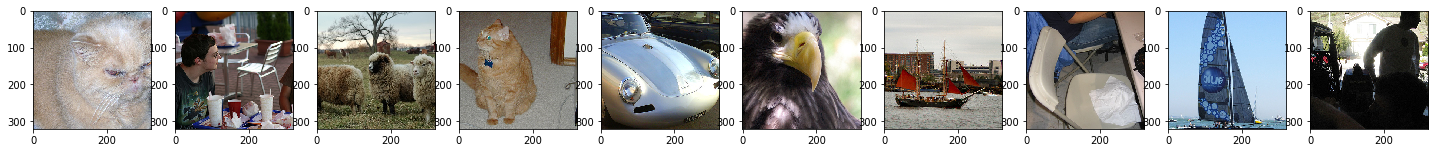

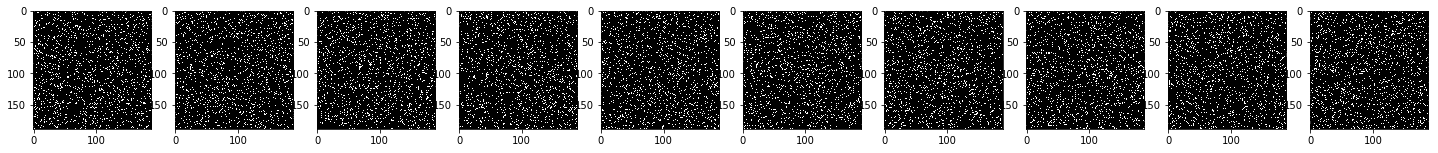

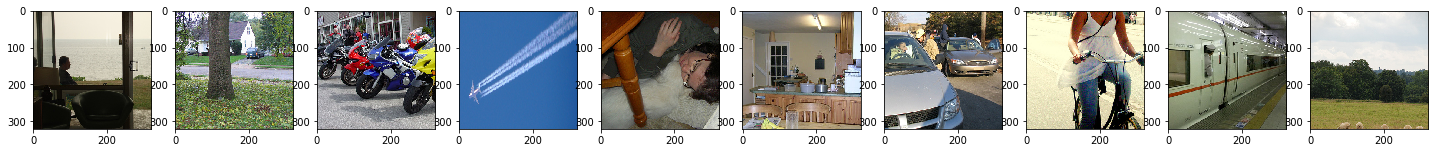

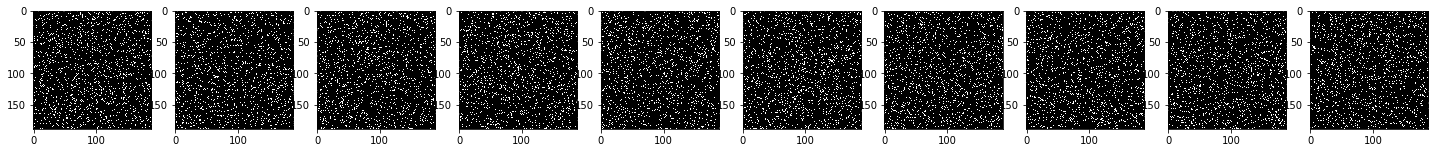

In [17]:
g = generator(imgaug_list, INPUT_SHAPE, DROPOUT_SHAPE, s, batch_size, p)
for i in range(3):
    gg = next(g)
    plt.figure(figsize=(25,25))
    for i in range(batch_size):
        plt.subplot(1,batch_size,i+1)
        plt.imshow(gg[0][0][i])
    
    plt.show()
    
    plt.figure(figsize=(25,25))
    for i in range(batch_size):
        plt.subplot(1,batch_size,i+1)
        plt.imshow(np.squeeze(gg[0][1][i]), 'gray')
    
    plt.show()

# Training

In [18]:
valset = imgaug_list[:1449]
trainset = imgaug_list[1449:]
len(trainset), len(valset)

(9133, 1449)

In [19]:
# set generator for training and validation
train_generator = generator(trainset, INPUT_SHAPE, DROPOUT_SHAPE, s, batch_size, p)
val_generator = generator(valset, INPUT_SHAPE, DROPOUT_SHAPE, s, 1, p, shuffle=False)

In [74]:
# set callback of checkpoint, learning rate scheduler
if not os.path.isdir('./checkpoint'):
    os.mkdir('./checkpoint')
if not os.path.isdir('./history'):
    os.mkdir('./history')
if not os.path.isdir('./logs'):
    os.mkdir('./logs')
    
def lrscheduler(epoch, lr):
    if epoch != 0 and epoch % 10 == 0:
        return lr * 0.5
    else:
        return lr

callbacks = [ModelCheckpoint(filepath='./checkpoint/classification_{epoch:04d}_{val_acc:.4f}.h5',
                             monitor='val_acc',
                             verbose=1,
                             mode='max'),
             LearningRateScheduler(schedule=lrscheduler,
                                   verbose=1),
             TensorBoard(batch_size=batch_size),
             CSVLogger(filename='./history/classification.csv', append=True)]

In [75]:
backbone.fit_generator(generator=train_generator,
                       steps_per_epoch=len(trainset)//batch_size,
                       epochs=200,
                       verbose=1,
                       callbacks=callbacks,
                       validation_data=val_generator,
                       validation_steps=len(valset),
                       initial_epoch=0)

Epoch 1/200

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
913/913 [==============================] - 357s 391ms/step - loss: 4.4588 - acc: 0.7209 - val_loss: 4.4439 - val_acc: 0.7219

Epoch 00001: saving model to ./checkpoint/classification_0001_0.7219.h5
Epoch 2/200

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
913/913 [==============================] - 357s 391ms/step - loss: 4.4692 - acc: 0.7203 - val_loss: 4.4439 - val_acc: 0.7219

Epoch 00002: saving model to ./checkpoint/classification_0002_0.7219.h5
Epoch 3/200

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
913/913 [==============================] - 357s 391ms/step - loss: 4.4701 - acc: 0.7202 - val_loss: 4.4439 - val_acc: 0.7219

Epoch 00003: saving model to ./checkpoint/classification_0003_0.7219.h5
Epoch 4/200

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
913/913 [=============

KeyboardInterrupt: 

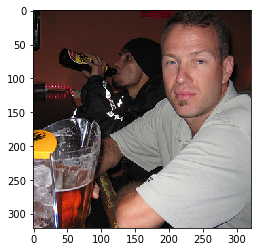

In [22]:
valimg, vallabel = next(val_generator)
plt.imshow(valimg[0][0])

In [23]:
for i, l in enumerate(backbone.layers):
    print(i, l)

0 <keras.engine.input_layer.InputLayer object at 0x7f9e3b096550>
1 <keras.layers.convolutional.Conv2D object at 0x7f9e3ba81978>
2 <keras.layers.convolutional.Conv2D object at 0x7f9ec4074b38>
3 <keras.layers.pooling.MaxPooling2D object at 0x7f9e3b0966d8>
4 <keras.layers.convolutional.Conv2D object at 0x7f9e3b0a07b8>
5 <keras.layers.convolutional.Conv2D object at 0x7f9e3b0a0630>
6 <keras.layers.pooling.MaxPooling2D object at 0x7f9e3b05d0b8>
7 <keras.layers.convolutional.Conv2D object at 0x7f9e3aff8550>
8 <keras.layers.convolutional.Conv2D object at 0x7f9e3aff83c8>
9 <keras.layers.convolutional.Conv2D object at 0x7f9e3b018cf8>
10 <keras.layers.pooling.MaxPooling2D object at 0x7f9e3b02d320>
11 <keras.layers.convolutional.Conv2D object at 0x7f9e3afe2550>
12 <keras.layers.convolutional.Conv2D object at 0x7f9e3afe23c8>
13 <keras.layers.convolutional.Conv2D object at 0x7f9e3af82cf8>
14 <keras.layers.pooling.MaxPooling2D object at 0x7f9e3af9b320>
15 <keras.layers.convolutional.Conv2D object at 

In [24]:
backbone_medi = K.function([backbone.input[0], backbone.input[1], K.learning_phase()], [backbone.get_layer(index=17).output])

In [25]:
medi = backbone_medi([valimg[0], valimg[1], 0])
medi[0].shape

(1, 21, 21, 512)

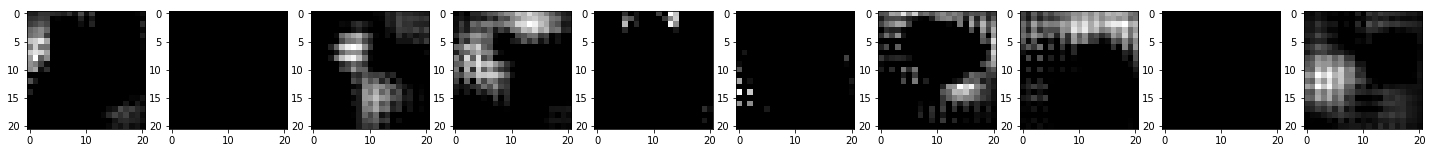

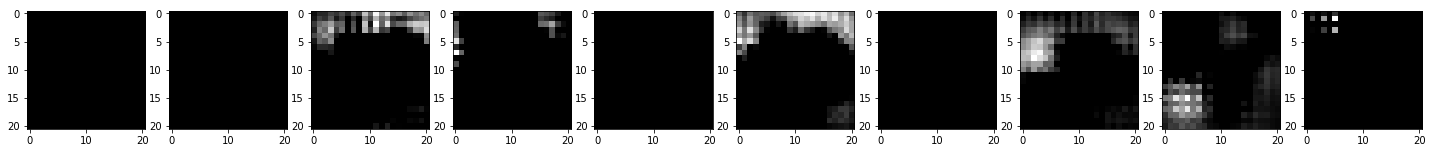

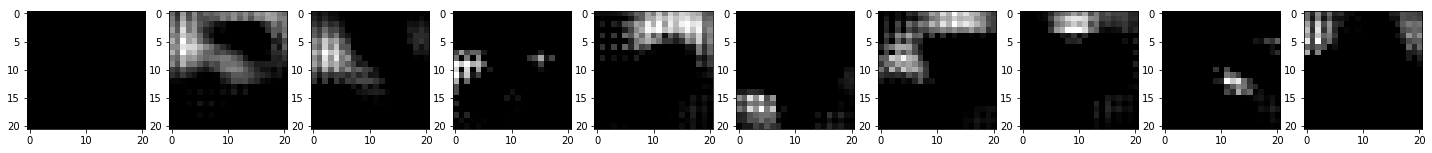

In [26]:
for j in range(3):
    plt.figure(figsize=(25,25))
    for i in range(10):
        plt.subplot(j+1,10,i+1)
        plt.imshow(medi[0][0,...,j*10+i], 'gray')
    plt.show()

In [27]:
backbone_medi = K.function([backbone.input[0], backbone.input[1], K.learning_phase()], [backbone.get_layer(index=21).output])

In [28]:
medi = backbone_medi([valimg[0], valimg[1], 0])
medi[0].shape

(1, 189, 189, 512)

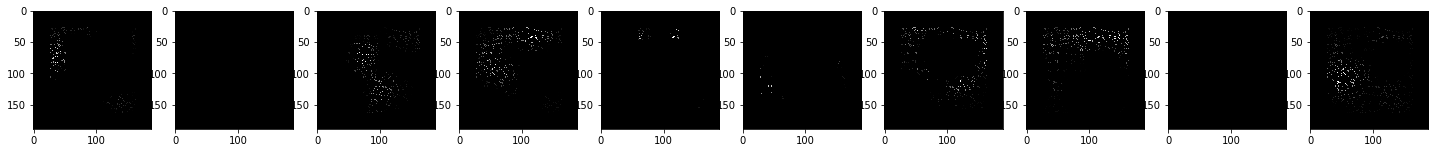

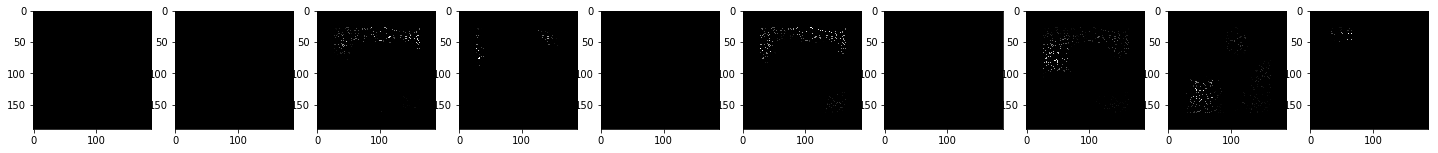

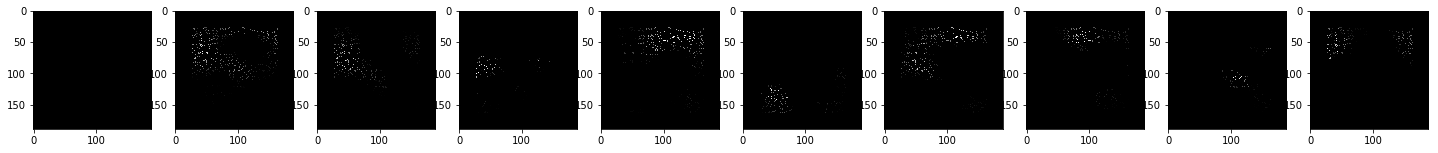

In [29]:
for j in range(3):
    plt.figure(figsize=(25,25))
    for i in range(10):
        plt.subplot(j+1,10,i+1)
        plt.imshow(medi[0][0,...,j*10+i], 'gray')
    plt.show()

In [30]:
backbone_func = K.function([backbone.input[0], backbone.input[1], K.learning_phase()], [backbone.get_layer(index=22).output])

In [31]:
result = backbone_func([valimg[0], valimg[1], 0])

In [32]:
result[0].shape

(1, 21, 21, 21)

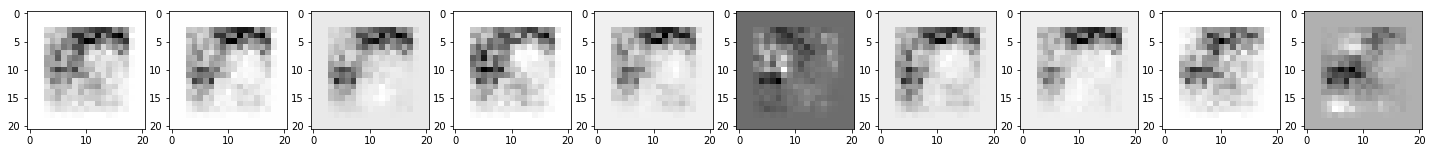

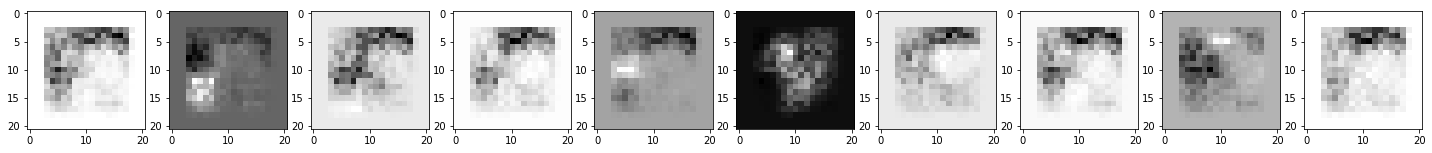

In [33]:
for j in range(2):
    plt.figure(figsize=(25,25))
    for i in range(10):
        plt.subplot(j+1,10,i+1)
        plt.imshow(result[0][0,...,j*10+i], 'gray')
    plt.show()

In [74]:
res = backbone.predict_on_batch(valimg)

In [75]:
res

array([[4.2146527e-32, 1.7414073e-18, 1.4753020e-11, 1.9173474e-17,
        2.5607605e-14, 8.9322704e-01, 1.2760058e-18, 4.6657518e-11,
        3.8600640e-14, 2.4799473e-04, 3.6649349e-27, 9.5924169e-01,
        1.4852645e-09, 7.2429807e-17, 2.9234945e-07, 1.0000000e+00,
        1.3744654e-09, 5.0133164e-17, 5.3725199e-08, 3.9165324e-17,
        2.5253248e-04]], dtype=float32)

In [68]:
np.argmax(res)

15

In [69]:
print([i for i, t in enumerate((res[0] > .35).astype('float32')) if t == 1], 
      (res[0] > .35).astype('float32'))
print([i for i, t in enumerate(vallabel[0]) if t == 1], 
      vallabel[0])

[5, 11, 15] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[5, 15] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [70]:
vallabel[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0.])

In [79]:
[k for k, v in class_dict.items() if v == np.argmax(res)]

['person']

# Get Localization Map using Grad-CAM

In [96]:
def gradcam(model, cls, img):
    y_cls = model.output[0, cls]
    conv_output = model.get_layer(index=22).output
    grads = K.gradients(y_cls, conv_output)[0]
    grads_function = K.function([model.input[0], model.input[1]], [conv_output, grads])
    
    output, grads_val = grads_function([img[0], img[1]])
    output, grads_val = np.squeeze(output), np.squeeze(grads_val)
    
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    # Process CAM
    cam = cv2.resize(cam, (img[0].shape[1], img[0].shape[2]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

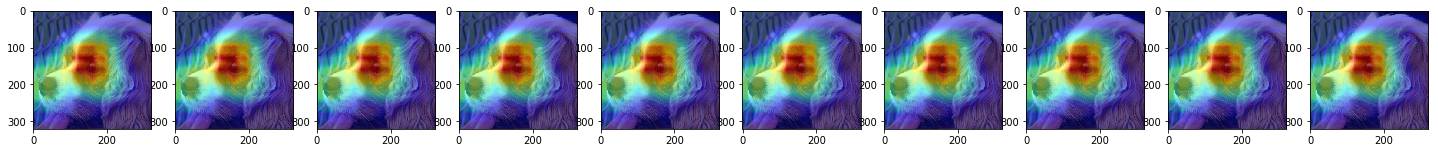

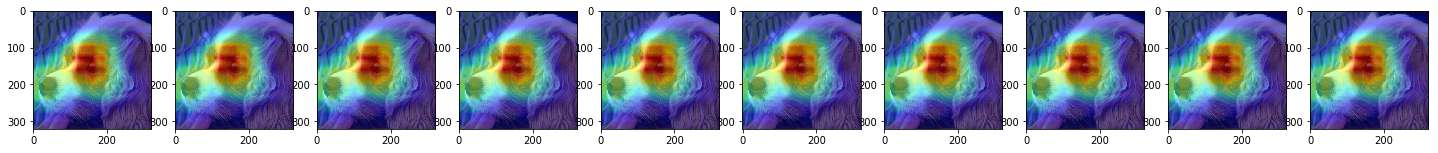

In [63]:
# 17
plt.figure(figsize=(25,25))
flag = True
for i in range(1,21):
    cam = gradcam(backbone, np.argmax(res), [valimg[0], _set_dropoutmap(DROPOUT_SHAPE, s, p)[np.newaxis,...]])
    plt.subplot(1,10,i%11 if i < 11 else i%11+1)
    plt.imshow(valimg[0][0])
    plt.imshow(cam, cmap='jet', alpha=.5)
    if i == 10:
        plt.show()
        plt.figure(figsize=(25,25))
plt.show()

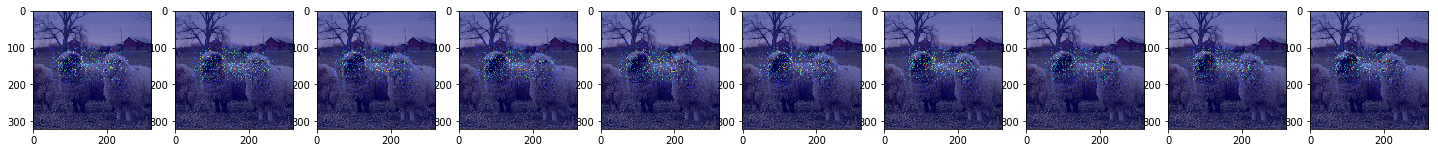

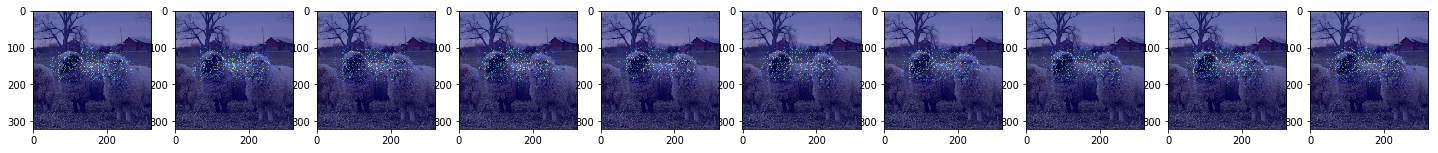

In [40]:
# 21
plt.figure(figsize=(25,25))
flag = True
for i in range(1,21):
    cam = gradcam(backbone, np.argmax(res), [valimg[0], _set_dropoutmap(DROPOUT_SHAPE, s, p)[np.newaxis,...]])
    plt.subplot(1,10,i%11 if i < 11 else i%11+1)
    plt.imshow(valimg[0][0])
    plt.imshow(cam, cmap='jet', alpha=.5)
    if i == 10:
        plt.show()
        plt.figure(figsize=(25,25))
plt.show()

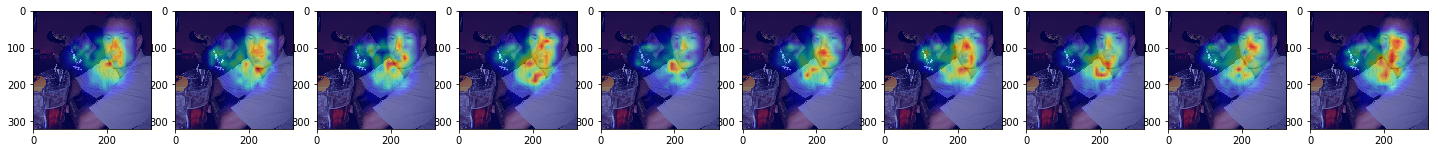

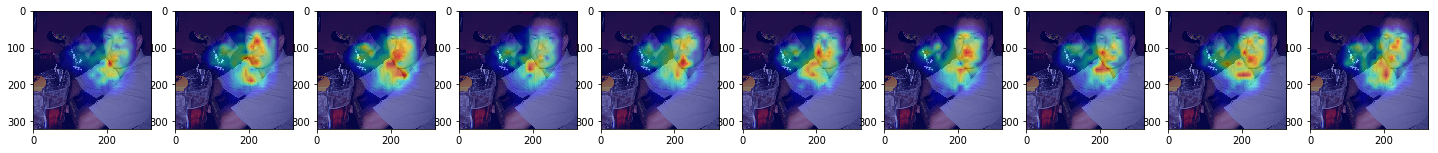

In [97]:
# 22
plt.figure(figsize=(25,25))
flag = True
for i in range(1,21):
    cam = gradcam(backbone, np.argmax(res), [valimg[0], _set_dropoutmap(DROPOUT_SHAPE, s, p)[np.newaxis,...]])
    plt.subplot(1,10,i%11 if i < 11 else i%11+1)
    plt.imshow(valimg[0][0])
    plt.imshow(cam, cmap='jet', alpha=.5)
    if i == 10:
        plt.show()
        plt.figure(figsize=(25,25))
plt.show()

In [98]:
for i in range(200):
    if i % 10 == 0:
        print(i)
    cam = gradcam(backbone, np.argmax(res), [valimg[0], _set_dropoutmap(DROPOUT_SHAPE, s, p)[np.newaxis,...]])
    if i == 0:
        localizationmap = np.zeros_like(cam)
        localizationmap += cam
    else:
        localizationmap += cam

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


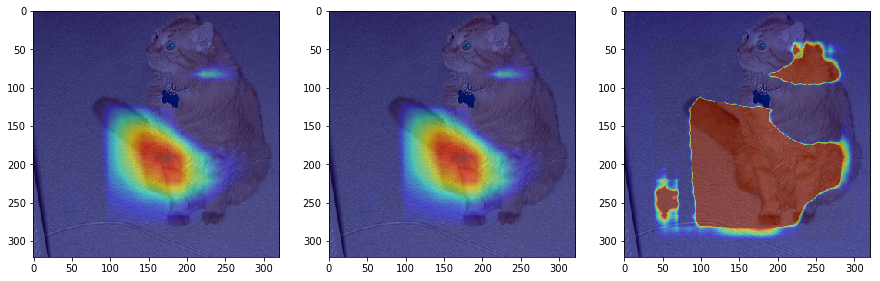

In [65]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(valimg[0][0])
plt.imshow(localizationmap/200, cmap='jet', alpha=.5)
plt.subplot(132)
plt.imshow(valimg[0][0])
plt.imshow(localizationmap/localizationmap.max(), cmap='jet', alpha=.5)
plt.subplot(133)
plt.imshow(valimg[0][0])
plt.imshow(np.clip(localizationmap, 0, 1), cmap='jet', alpha=.5)
plt.show()

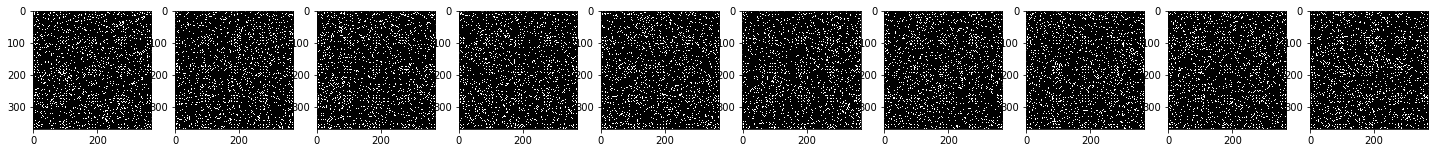

In [215]:
plt.figure(figsize=(25,25))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(np.squeeze(_set_dropoutmap(DROPOUT_SHAPE, s, p)), 'gray')
plt.show()

In [ ]:
y_cls = vgg.output[0, np.argmax(result)]
conv_output = vgg.get_layer(index=17).output
grads = K.gradients(y_cls, conv_output)[0]
grads_function = K.function([vgg.input], [conv_output, grads])

output, grad_val = grads_function([img])
output, grad_val = np.squeeze(output), np.squeeze(grad_val)
print(output.shape, grad_val.shape)

# Set segmentation model

In [ ]:
'''https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/crf.py
'''
